In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
from nltk.corpus import stopwords


In [102]:

def load_sentences(domain='pool', data_type=['train', 'test', 'valid']):
    sents = None

    for dt in ['train', 'test', 'valid']:
        if dt not in data_type:
            continue
        
        dt_sents = pd.read_csv('./data/' + domain + '/' + dt + '/sentences.txt', sep='\n', header=None)
        if sents is None:
            sents = dt_sents
        else:
            sents = pd.concat([sents, dt_sents], axis=0)

    sents.columns = ['sentence']
    return sents



def cal_sent_len(domain='pool', sub_dataset=['train', 'valid', 'test']):
    sents = load_sentences(domain, sub_dataset)
    sent_len_all_domain = pd.Series([ len( sent.split() ) for sent in sents['sentence'] ])
    return sent_len_all_domain



from wordcloud import WordCloud

def plot_word_cloud(text, size=(8, 8)):
    wordcloud = WordCloud(
        background_color = 'white',
        random_state = 42
    ).generate(text)

    plt.figure( figsize=size )
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


def cal_top_words(words, freqs, n=100, rare=False):
    words = np.array(words)
    freqs = np.array(freqs)


    if rare:
        top_n_words = words[freqs < n]
        top_n_freqs = freqs[freqs < n]
    else:
        top_n_words = words[freqs > n]
        top_n_freqs = freqs[freqs > n]

    top_word_freq = {w: top_n_freqs[i] for i,w in enumerate(top_n_freqs)}

    return top_word_freq, top_n_words, top_n_freqs



stop = stopwords.words('english')
def cal_word_freq(corpus):
    words = []
    for sent in corpus:
        for w in sent.split():
#             w_l = w.lower()
#             if w_l.strip() in stop or w_l in string.punctuation or w_l.isdigit() or w_l in ['\'s', 'said', "n't", '--'] or '0' in w_l:
#                 continue
            words.append(w)

    print('total words ', len(words))
    
    w_freq = nltk.FreqDist(words)

    return {w: q for w, q in w_freq.items()}, np.array(list(w_freq.keys())), np.array(list(w_freq.values()))


# Rare Words

sents with different scarcity of rare words (e.g. contains word <1% occurance freq)


## Data(train/valid/test) from all domains

In [88]:
sents_all_domain = load_sentences('pool', ['train', 'valid', 'test'])

sents_all_domain.shape


(112511, 1)

In [89]:
word_counts, words, freqs = cal_word_freq(sents_all_domain['sentence'].tolist())


total words  2376914


In [95]:
pd.Series(freqs).describe()


count     64318.000000
mean         36.955658
std         913.607124
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max      113154.000000
dtype: float64

## Word cloud

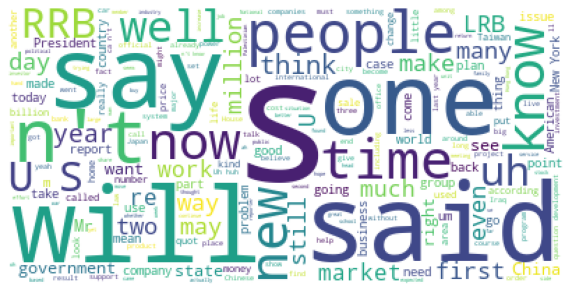

In [113]:
# corpus cloud
plot_word_cloud(' '.join(sents_all_domain['sentence'].tolist()), size=(10, 10))


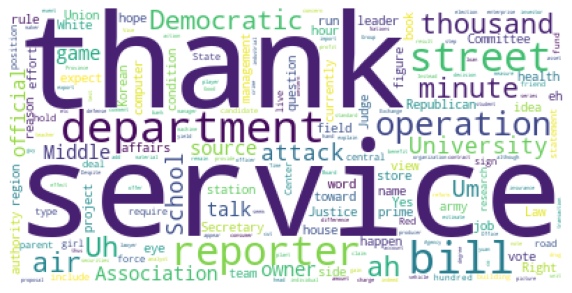

In [115]:
min_freqs = 100
max_freqs = 500
range_words = words[ 
    (freqs <= max_freqs) & (freqs > min_freqs)
]
plot_word_cloud(' '.join(range_words), size=(10, 10))


## Rare word freq (freq<100)

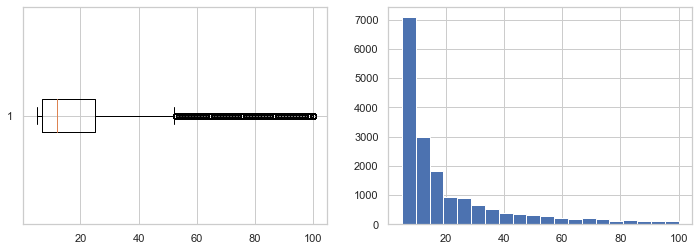

count    17627.000000
mean        20.460260
std         20.197309
min          5.000000
25%          7.000000
50%         12.000000
75%         25.000000
max        100.000000
dtype: float64

In [139]:
rare_freq = freqs[ (freqs <= 100) & (freqs > 4) ]



fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].boxplot(x=rare_freq, vert=False)
ax[1].hist(x=rare_freq, bins=20)
plt.show()

pd.Series(rare_freq).describe()


In [142]:
print('upper IQR: ', (25 - 7) * 1.5 + 25)


upper IQR:  52.0


In [143]:

print([7, 12, 25, 50, 100])


[7, 12, 25, 50, 100]


# Sentence Length

## 1. Sent(train/valid/test) from all domains

In [3]:
sent_len_all_domain = cal_sent_len('pool', ['train', 'valid', 'test'])

sent_len_all_domain.describe()


count    112511.000000
mean         21.126059
std          14.928275
min           2.000000
25%          10.000000
50%          18.000000
75%          29.000000
max         298.000000
dtype: float64

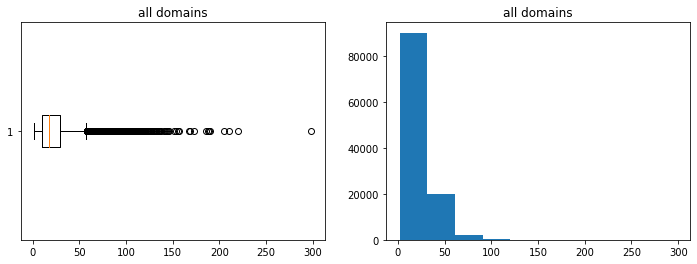

In [4]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].boxplot(x=sent_len_all_domain, vert=False)
ax[0].set_title('all domains')

# ax[1].hist(x=sent_len_all_domain[ sent_len_all_domain < 10], bins=20)
ax[1].hist(x=sent_len_all_domain)
ax[1].set_title('all domains')

plt.show()


## 2. 3. Sent(train/valid/test) from In-Domain

In [27]:

domains = ['bc', 'bn', 'mz', 'nw', 'tc', 'wb']

in_domain_split_type = ['train', 'valid', 'test']
# in_domain_split_type = ['test']
sents_bc = load_sentences('bc', in_domain_split_type)
sents_bn = load_sentences('bn', in_domain_split_type)
sents_mz = load_sentences('mz', in_domain_split_type)
sents_nw = load_sentences('nw', in_domain_split_type)
sents_tc = load_sentences('tc', in_domain_split_type)
sents_wb = load_sentences('wb', in_domain_split_type)

sent_len_sents_bc = pd.Series([ len( sent.split() ) for sent in sents_bc['sentence'] ])
sent_len_sents_bn = pd.Series([ len( sent.split() ) for sent in sents_bn['sentence'] ])
sent_len_sents_mz = pd.Series([ len( sent.split() ) for sent in sents_mz['sentence'] ])
sent_len_sents_nw = pd.Series([ len( sent.split() ) for sent in sents_nw['sentence'] ])
sent_len_sents_tc = pd.Series([ len( sent.split() ) for sent in sents_tc['sentence'] ])
sent_len_sents_wb = pd.Series([ len( sent.split() ) for sent in sents_wb['sentence'] ])

sent_len_sents_bc.shape


(16162,)

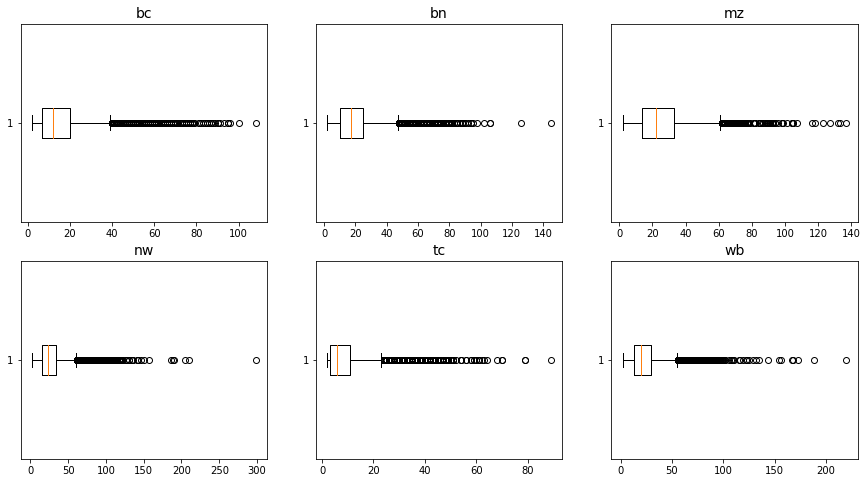

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0,0].boxplot(x=sent_len_sents_bc, vert=False)
ax[0,0].set_title('bc', fontsize=14)

ax[0,1].boxplot(x=sent_len_sents_bn, vert=False)
ax[0,1].set_title('bn', fontsize=14)

ax[0,2].boxplot(x=sent_len_sents_mz, vert=False)
ax[0,2].set_title('mz', fontsize=14)

ax[1,0].boxplot(x=sent_len_sents_nw, vert=False)
ax[1,0].set_title('nw', fontsize=14)

ax[1,1].boxplot(x=sent_len_sents_tc, vert=False)
ax[1,1].set_title('tc', fontsize=14)

ax[1,2].boxplot(x=sent_len_sents_wb, vert=False)
ax[1,2].set_title('wb', fontsize=14)

plt.show()

avg [15.208699418388813, 19.461144578313252, 24.750636780438104, 26.690857000498255, 8.57938838358519, 23.0728426636355]
min [2, 2, 2, 2, 2, 2]
max [108, 145, 137, 298, 89, 220]


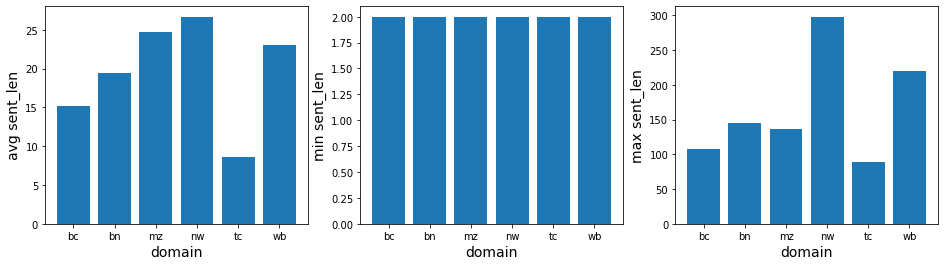

In [29]:

avg_sent_len_per_domain = [ 
    np.mean(sent_len_sents_bc), np.mean(sent_len_sents_bn), 
    np.mean(sent_len_sents_mz), np.mean(sent_len_sents_nw),
    np.mean(sent_len_sents_tc), np.mean(sent_len_sents_wb)
]
min_sent_len_per_domain = [ 
    np.min(sent_len_sents_bc), np.min(sent_len_sents_bn), 
    np.min(sent_len_sents_mz), np.min(sent_len_sents_nw),
    np.min(sent_len_sents_tc), np.min(sent_len_sents_wb)
]
max_sent_len_per_domain = [ 
    np.max(sent_len_sents_bc), np.max(sent_len_sents_bn), 
    np.max(sent_len_sents_mz), np.max(sent_len_sents_nw),
    np.max(sent_len_sents_tc), np.max(sent_len_sents_wb)
]

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].bar(x=domains, height=avg_sent_len_per_domain)
# ax.set_title('avg sent_len by domain', fontsize=14)
ax[0].set_xlabel('domain', fontsize=14)
ax[0].set_ylabel('avg sent_len', fontsize=14)

ax[1].bar(x=domains, height=min_sent_len_per_domain)
# ax.set_title('avg sent_len by domain', fontsize=14)
ax[1].set_xlabel('domain', fontsize=14)
ax[1].set_ylabel('min sent_len', fontsize=14)

ax[2].bar(x=domains, height=max_sent_len_per_domain)
# ax.set_title('avg sent_len by domain', fontsize=14)
ax[2].set_xlabel('domain', fontsize=14)
ax[2].set_ylabel('max sent_len', fontsize=14)


print('avg',avg_sent_len_per_domain)
print('min',min_sent_len_per_domain)
print('max',max_sent_len_per_domain)


## 3. Sent(train/valid/test) from leave-one-out domains

In [77]:
leave_one_domain = 'nw'

sent_len_wo_domain = cal_sent_len('pool_' + leave_one_domain, ['train', 'valid', 'test'])
sent_len_wo_domain.describe()


count    72371.000000
mean        18.039588
std         13.773613
min          2.000000
25%          8.000000
50%         15.000000
75%         25.000000
max        220.000000
dtype: float64

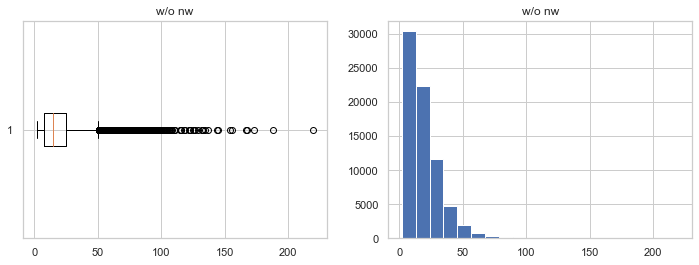

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].boxplot(x=sent_len_wo_domain, vert=False)
ax[0].set_title('w/o ' + leave_one_domain)

# ax[1].hist(x=sent_len_wo_domain[sent_len_wo_domain<86], bins=20)
ax[1].hist(x=sent_len_wo_domain, bins=20)
ax[1].set_title('w/o ' + leave_one_domain)

plt.show()


## 4. Threshold of set_len

In [79]:
# 1.5*IQR, 3*IQR
print('upper IQR: ', 29 + 1.5*(29-10))


upper IQR:  57.5


### Counts by threshold (all domains)

In [80]:
# [ 5, 10(25%), 30(75%), 60(1.5IQR), max ]
# sen_len_threshold = [ 5, 10, 30, 60, max(sent_len_all_domain) ]
sen_len_threshold = [ 5, 10, 25, 50, max(sent_len_all_domain) ]

sen_len_threshold


[5, 10, 25, 50, 298]

counts [12429. 16866. 47834. 30613.  4769.]


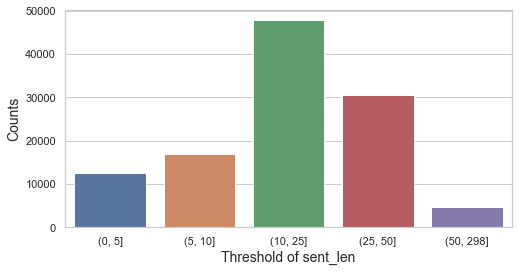

In [81]:
prev_v = 0
x_label = []
sen_len_counts_by_threshold = np.zeros(len(sen_len_threshold))
for i, v in enumerate(sen_len_threshold):
    range_sent_len = sent_len_all_domain[ 
        (sent_len_all_domain <= v) & (sent_len_all_domain > prev_v)
    ]

    x_label.append('({}, {}]'.format(prev_v, v))

    prev_v = v
    
    sen_len_counts_by_threshold[i] = len(range_sent_len)
    
print('counts', sen_len_counts_by_threshold)


sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x=x_label, y=sen_len_counts_by_threshold)
ax.set_ylabel('Counts', fontsize=14)
ax.set_xlabel('Threshold of sent_len', fontsize=14)

plt.show()


### Hist of sent_len(all domains)

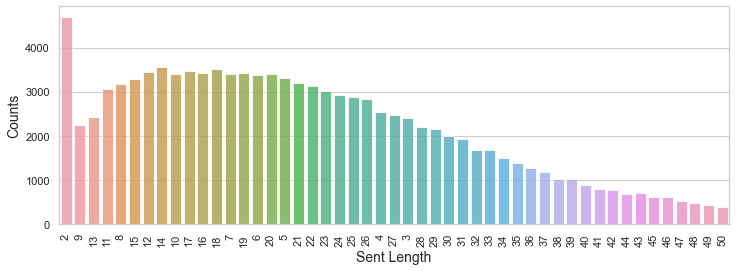

In [82]:
min_len_breakpoint = 0
max_len_breakpoint = 50
top_sent_len = sent_len_all_domain[ 
    (sent_len_all_domain <= max_len_breakpoint) & (sent_len_all_domain > min_len_breakpoint)
].value_counts()

fig, ax = plt.subplots(figsize=(12, 4))
# fig, ax = plt.subplots()
sns.barplot(x=top_sent_len.index, y=top_sent_len.values, alpha=0.8)

# ax.set_title('Distribution of training sentence length from all domains')
ax.set_ylabel('Counts', fontsize=14)
ax.set_xlabel('Sent Length', fontsize=14)
plt.xticks(range(len(top_sent_len.index)), top_sent_len.index, rotation='vertical')

plt.show()


### Counts by threshold (leave one domains)

In [83]:

# [ 5, 10(25%), 30(75%), 60(1.5IQR), max ]
# sen_len_threshold = [ 5, 10, 30, 60, max(sent_len_wo_domain) ]
one_sen_len_threshold = [ 5, 10, 25, 50, max(sent_len_wo_domain) ]

one_sen_len_threshold


[5, 10, 25, 50, 220]

counts [11229. 14014. 30294. 14695.  2139.]


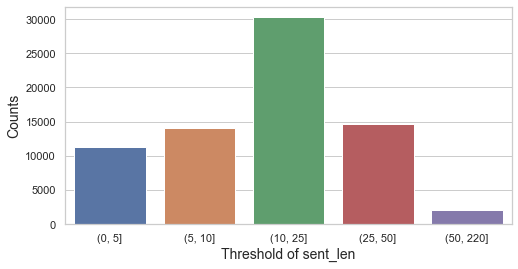

In [87]:
prev_v = 0
one_x_label = []
one_sen_len_counts_by_threshold = np.zeros(len(one_sen_len_threshold))

for i, v in enumerate(one_sen_len_threshold):
    range_sent_len = sent_len_wo_domain[ 
        (sent_len_wo_domain <= v) & (sent_len_wo_domain > prev_v)
    ]

    one_x_label.append('({}, {}]'.format(prev_v, v))

    prev_v = v
    
    one_sen_len_counts_by_threshold[i] = len(range_sent_len)

print('counts', one_sen_len_counts_by_threshold)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=one_x_label, y=one_sen_len_counts_by_threshold)

ax.set_ylabel('Counts', fontsize=14)
ax.set_xlabel('Threshold of sent_len', fontsize=14)
plt.show()
